In [0]:
#!pip install rake_nltk

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import remove_stopwords, stem_text, strip_tags
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from rake_nltk import Rake
warnings.filterwarnings(action='ignore')

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/Temp/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
##shape

df.shape

(159571, 8)

Text(0, 0.5, '')

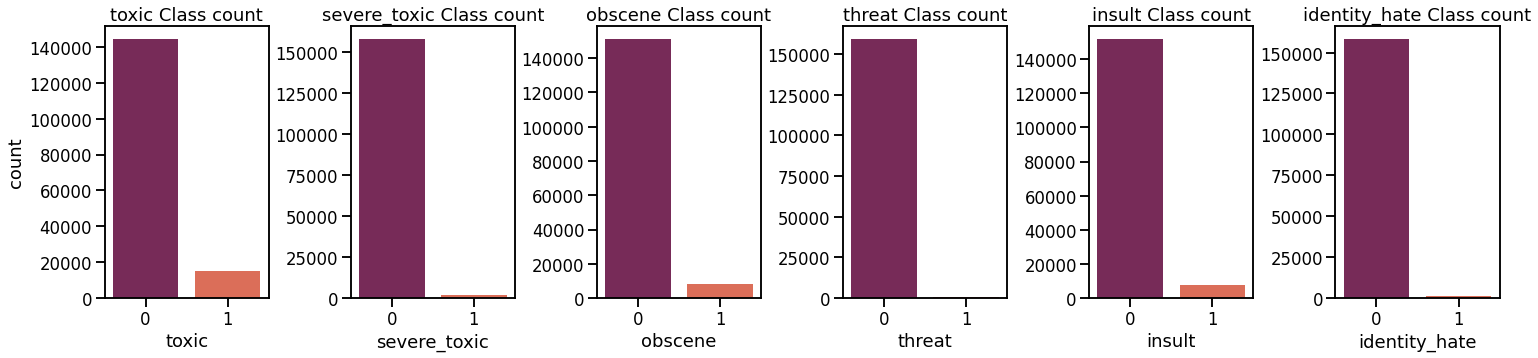

In [63]:
sns.set_context('talk')

label = df.iloc[:, 2:].columns

plt.figure(figsize=(25,5))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

plt.subplot(1, 6, 1)
sns.countplot(df[label[0]], palette='rocket')
plt.title(label[0] +' Class count')

plt.subplot(1, 6, 2)
sns.countplot(df[label[1]], palette='rocket')
plt.title(label[1] +' Class count')
plt.ylabel('')

plt.subplot(1, 6, 3)
sns.countplot(df[label[2]], palette='rocket')
plt.title(label[2] +' Class count')
plt.ylabel('')

plt.subplot(1, 6, 4)
sns.countplot(df[label[3]], palette='rocket')
plt.title(label[3] +' Class count')
plt.ylabel('')

plt.subplot(1, 6, 5)
sns.countplot(df[label[4]], palette='rocket')
plt.title(label[4] +' Class count')
plt.ylabel('')

plt.subplot(1, 6, 6)
sns.countplot(df[label[5]], palette='rocket')
plt.title(label[5] +' Class count')
plt.ylabel('')

In [13]:
#Null values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Removing Numbers, Special Characters & Stop Words

In [0]:
### removing html tags, special characters and numbers, words with length less than 3 & Stop words

clean_comments = [ ]

#r = Rake(language='english')

def data_cleaning(data, empty_list):
    for doc in data:

        ############# HTML Tag remover
        #html = strip_tags(str(doc))                        <----- Gensim tag remover
        html = BeautifulSoup(str(doc), 'lxml').get_text()

        ############# Digit remover
        #dig = re.sub(" \d+", " ", html)
        dig = re.sub('[0-9]', '', html)

        ############# Special characters remover
        sp_char = re.sub('[^A-Za-z0-9]+', ' ', dig)

        ############# Removing words less than 3 & eliminating stop words
        len_3 = re.sub(r'\b\w{1,3}\b', '', sp_char)
        sw = remove_stopwords(len_3)

        ############# Stemmer
        #stem = stem_text(sw)

        ############# Rake
        #rake = r.extract_keywords_from_text(str(sw))
        #tags = r.get_ranked_phrases()
        #rake_tags.append(tags)


        ############# Append Empty list
        empty_list.append(sw)


# Applying function
data_cleaning(df['comment_text'], clean_comments)

In [14]:
df['clean_comments'] = clean_comments

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation edits username Hardcore Metallica ...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,matches background colour seemingly stuck Than...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,trying edit constantly removing relevant infor...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,More real suggestions improvement wondered sec...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,hero chance remember page


In [15]:
df.clean_comments[0]

'Explanation edits username Hardcore Metallica reverted They weren vandalisms closure voted York Dolls remove template talk page retired'

### Rake

In [16]:
'''rake_comments = [ ]
final_comment = [ ]

r = Rake(language='english')

for i in df['comment_text']:
    r.extract_keywords_from_text(str(i))
    tags = r.get_ranked_phrases()
    rake_comments.append(tags)

for tag in rake_comments:
    string = ' '.join([str(elem) for elem in tag])
    final_comment.append(string)'''

"rake_comments = [ ]\nfinal_comment = [ ]\n\nr = Rake(language='english')\n\nfor i in df['comment_text']:\n    r.extract_keywords_from_text(str(i))\n    tags = r.get_ranked_phrases()\n    rake_comments.append(tags)\n\nfor tag in rake_comments:\n    string = ' '.join([str(elem) for elem in tag])\n    final_comment.append(string)"

### Train / Test Split

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputClassifier

predictor = df.iloc[:, -1].as_matrix()
dependent_var = df.iloc[:, 2:-1].as_matrix()

x_train, x_test, y_train, y_test = train_test_split(predictor, dependent_var, test_size= .3 , random_state=1)

#shape of train / test split
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((111699,), (47872,), (111699, 6), (47872, 6))

### Vectorization

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#### Count Vect. and tfidf vect.
cv = CountVectorizer(encoding='utf-8', lowercase=True, ngram_range=(1,2), strip_accents='ascii')
tfidf = TfidfVectorizer(encoding='utf-8', lowercase=True, ngram_range=(1,2), strip_accents='ascii')

#### Count Vect. transformation
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

#### tfidf vect. transformation
x_train_tf = tfidf.fit_transform(x_train)
x_test_tf = tfidf.transform(x_test)

#### Multinomial Naive Bayes - CV

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix

est_nb_cv = MultiOutputClassifier(MultinomialNB()).fit(x_train_cv, y_train)

pred_nb_cv = est_nb_cv.predict(x_test_cv)

print ('Accuracy :' , accuracy_score(y_test, pred_nb_cv), '\n')

print ('Classification Report : \n', classification_report(y_test, pred_nb_cv))

Accuracy : 0.9052264371657754 

Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.35      0.51      4695
           1       0.55      0.20      0.30       491
           2       0.92      0.38      0.53      2544
           3       0.80      0.03      0.05       154
           4       0.83      0.29      0.42      2387
           5       0.75      0.03      0.06       442

   micro avg       0.90      0.32      0.47     10713
   macro avg       0.80      0.21      0.31     10713
weighted avg       0.89      0.32      0.46     10713
 samples avg       0.03      0.02      0.03     10713



#### Multinomial Naive Bayes - Tfidf

In [21]:
est_nb_tf = MultiOutputClassifier(MultinomialNB(fit_prior=False)).fit(x_train_tf, y_train)

pred_nb_tf = est_nb_tf.predict(x_test_tf)

print ('Accuracy :' , accuracy_score(y_test, pred_nb_tf), '\n')

print ('Classification Report : \n', classification_report(y_test, pred_nb_tf))

Accuracy : 0.9021557486631016 

Classification Report : 
               precision    recall  f1-score   support

           0       0.95      0.27      0.42      4695
           1       0.41      0.05      0.09       491
           2       0.92      0.30      0.46      2544
           3       0.04      0.01      0.01       154
           4       0.79      0.21      0.33      2387
           5       0.33      0.02      0.05       442

   micro avg       0.88      0.24      0.38     10713
   macro avg       0.57      0.14      0.23     10713
weighted avg       0.84      0.24      0.37     10713
 samples avg       0.03      0.02      0.02     10713



### Multilabel Confusion Matrix

In [0]:
### multilabel CM plot heatmap

sns.set_context('talk')

def multilabel_c_mat(cm, label):
    for i, j in zip(cm, label):
        plt.figure()
        sns.heatmap(i, cmap='seismic', annot=True, fmt='d')
        plt.title(j.replace('_', ' '))
        plt.plot()

In [75]:
np.arange(1,len(label))

array([1, 2, 3, 4, 5, 6])

In [0]:
### multilabel CM plot heatmap

sns.set_context('talk')

def multilabel_c_mat(cm, label):
    plt.figure(figsize=(25,5))
    plt.subplots_adjust(wspace=0.4, hspace=0.3)

    for i, j, k in zip(cm, label, np.arange(1, len(label))):
        plt.subplot(1, 6, k)
        #plt.figure()
        sns.heatmap(i, cmap='seismic', annot=True, fmt='d', cbar=False)
        plt.title(j.replace('_', ' '))
        #plt.plot()

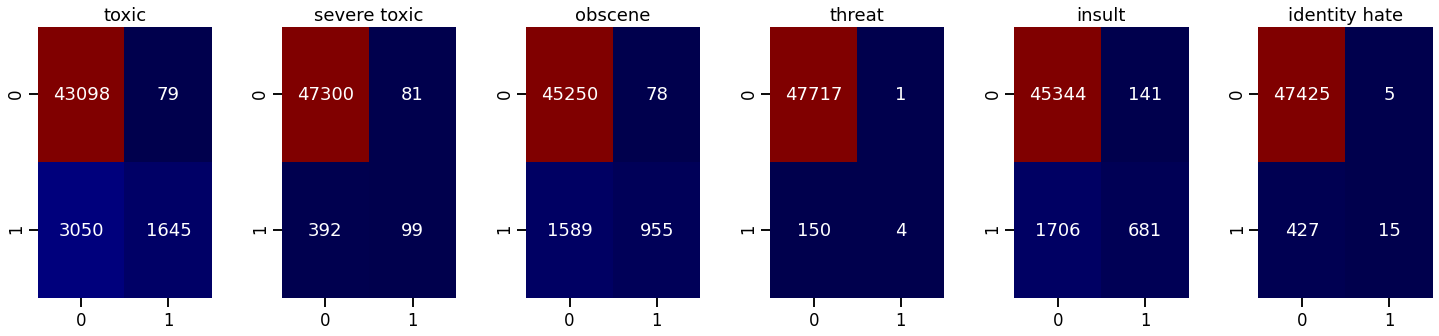

In [81]:
#Count vectorizer CM
multilabel_c_mat(multilabel_confusion_matrix(y_test, pred_nb_cv), label)

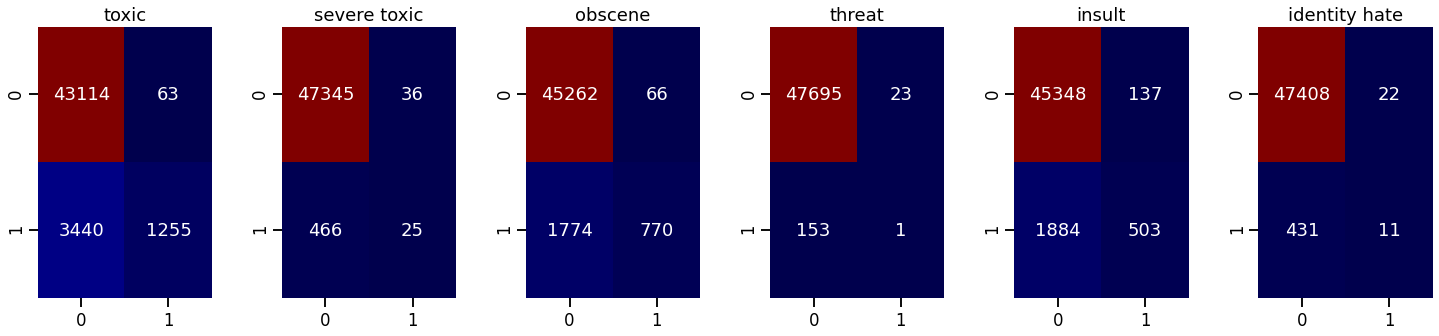

In [82]:
#tfidf confusion matrix
multilabel_c_mat(multilabel_confusion_matrix(y_test, pred_nb_tf), label)

In [83]:
y_test[:, 0:1].shape

(47872, 1)

In [26]:
'''from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(MultiOutputClassifier(MultinomialNB()))
viz.fit(x_train_cv, y_train[:, 0:1])
viz.score(x_test_cv, y_test[:, 0:1])
viz.show()
'''

'from yellowbrick.classifier import PrecisionRecallCurve\n\nviz = PrecisionRecallCurve(MultiOutputClassifier(MultinomialNB()))\nviz.fit(x_train_cv, y_train[:, 0:1])\nviz.score(x_test_cv, y_test[:, 0:1])\nviz.show()\n'

In [27]:
'''from yellowbrick.classifier import PrecisionRecallCurve

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(
    MultinomialNB(), per_class=True, iso_f1_curves=True,
    fill_area=False, micro=False, classes=label
)
viz.fit(x_train_cv, y_train)
viz.score(x_test_cv, y_test)
viz.show()'''

'from yellowbrick.classifier import PrecisionRecallCurve\n\n# Create the visualizer, fit, score, and show it\nviz = PrecisionRecallCurve(\n    MultinomialNB(), per_class=True, iso_f1_curves=True,\n    fill_area=False, micro=False, classes=label\n)\nviz.fit(x_train_cv, y_train)\nviz.score(x_test_cv, y_test)\nviz.show()'

In [81]:
precision['micro'], recall.mean()

IndexError: ignored

In [53]:
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='MultinominalNB')

NameError: ignored

In [58]:
plot_precision_recall_curve(est_nb_cv, x_test_cv, pred_nb_cv[:, 0])

AttributeError: ignored

### Precision-Recall Curve

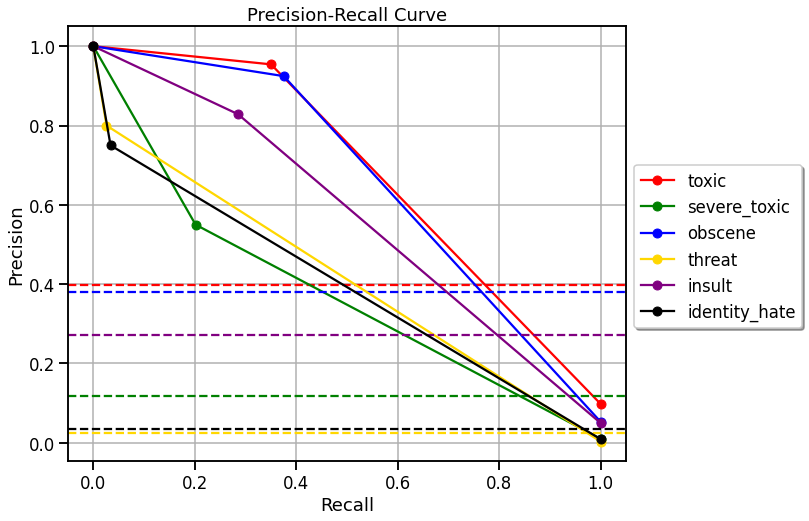

In [62]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10,8))
sns.set_context('talk')


for i, j, c in zip(range(len(label)), label, ('red', 'green', 'blue', 'gold', 'purple', 'black')):
    precision, recall, _ = precision_recall_curve(y_test[:, i], pred_nb_cv[:, i])
    average_precision = average_precision_score(y_test[:, i], pred_nb_cv[:, i])
    plt.plot(recall, precision, marker='o', label=j, color=c)
    plt.axhline(average_precision, linestyle='--', color=c)
    
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(bbox_to_anchor=(1, 0.7), shadow=True)

In [29]:
len(y_test.ravel())

287232

In [31]:
len(y_test)

47872